# VCF - Parametric low-pass filter

This notebook focuses on the implementation aspects of the VCF, i.e. fixed word sizes and such.

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

References:
- Basic filter structure from Stilson and Smith 1996 Analyzing the Moog VCF with Considerations for Digital Implementation
- Referred to in Valimaki 2006 Oscillator and Filter Algorithms for Virtual Analog Synthesis page 26.

In [1]:
import os
import subprocess
import textwrap

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io.wavfile
from numba import jit

%load_ext fortranmagic
%load_ext Cython

def get_chirp(fs=44100, fstart=20, fstop=20e3, amplitude=2**15, duration_s=10):
    t = np.arange(duration_s*fs)/fs
    x = amplitude * signal.chirp(t, f0=fstart, f1=fstop, t1=max(t), method="linear")
    return np.array(x, dtype=np.int16)

def frequency_response(callback, cutoff, resonance,
                       fs=44100, fstart=20, fstop=20e3, amplitude=2**15):
    # Callback arguments:
    # - x:         Filter input (List[int16])
    # - length:    Length of x (int)
    # - cutoff:    Cutoff argument (0-127)
    # - resonance: Resonance argument (0-127)
    x = get_chirp(fs=fs, fstart=fstart, fstop=fstop, amplitude=amplitude, duration_s=10)
    y = callback(x, len(x), cutoff, resonance)
    f = np.linspace(fstart, fstop, len(y))
    H = 1/amplitude * signal.hilbert(y)
    return f, H

def decorate_frequency_response(yrange=[-50, 10]):
    fig, ax = plt.gcf(), plt.gca()
    ax.grid(True, "both", "both")
    ax.legend()
    ax.set_xlim(20, 20e3)
    ax.set_ylim(*yrange)
    fig.tight_layout()

@jit
def nb_onepole(x, g, x1, y1):
    v = 1/1.3 * x + 0.3/1.3*x1
    y = (v-y1)*g + y1
    return y

/home/soren/.local/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


## Implementations

### Python

In [2]:
@jit
def map_cutoff(value):
    assert(0 <= value <= 127)
    b = 0.02
    a = (0.8-b) / (127*127)
    return a*value*value + b

@jit
def map_resonance(value):
    assert(0 <= value <= 127)
    b = 0.5
    a = (3.5-b) / 127
    return a*value + b
    
@jit
def vcf(x, length, cutoff, resonance):
    g = map_cutoff(cutoff)
    k = map_resonance(resonance)
    
    y = [0]*length
    w = [0, 0, 0, 0, 0] # Current sample
    d = [0, 0, 0, 0, 0] # Delayed sample
    
    # Feedback gain compensation form Valimaki
    G_comp = 0.5

    for n in range(1, length):     
        x_ = x[n]/16
        w[0] = x_ - (d[4]*k - G_comp*x_)
        w[1] = nb_onepole(w[0], g, d[0], d[1])
        w[2] = nb_onepole(w[1], g, d[1], d[2])
        w[3] = nb_onepole(w[2], g, d[2], d[3])
        w[4] = nb_onepole(w[3], g, d[3], d[4])

        for i in range(5):
            d[i] = w[i]

        y[n] = w[4]

    return y

### Fortran implementation

In [3]:
%%fortran -v

real function f_onepole(x, g, x1, y1)
    implicit none
    real, intent(in) :: x, g, x1, y1
    real :: v

    v = 1.0/1.3 * x + 0.3/1.3*x1
    f_onepole = (v-y1)*g + y1
end function

real function f_map_cutoff(midi)
    implicit none
    real, intent(in) :: midi
    real, parameter :: b = 0.02
    real, parameter :: a = (0.8-b) / (127*127)
    f_map_cutoff = a*midi*midi + b
end function

real function f_map_resonance(midi)
    implicit none
    real, intent(in) :: midi
    real, parameter :: b = 0.5
    real, parameter :: a = (3.5-b) / (127)
    f_map_resonance = a*midi + b
end function

subroutine f_vcf(x, length, cutoff, resonance, y)
    real, intent(in) :: cutoff, resonance
    integer, intent(in) :: length
    real, intent(in) :: x(:)
    real, intent(out) :: y(length)
    real, parameter :: G_comp = 0.5
    real :: w(5), d(5)
    real :: g, k, x_
    integer :: n

    g = f_map_cutoff(cutoff)
    k = f_map_resonance(resonance)
        
    w(:) = (/0, 0, 0, 0, 0/)
    d(:) = (/0, 0, 0, 0, 0/)
    
    do n = 1, size(x)
        x_ = x(n)/16.0
        w(1) = x_ - (d(5)*k - G_comp*x_)
        w(2) = f_onepole(w(1), g, d(1), d(2))
        w(3) = f_onepole(w(2), g, d(2), d(3))
        w(4) = f_onepole(w(3), g, d(3), d(4))
        w(5) = f_onepole(w(4), g, d(4), d(5))
        
        d(:) = w(:)
        y(n) = w(5)
    end do
end subroutine


Ok. The following fortran objects are ready to use: f_onepole, f_map_cutoff, f_map_resonance, f_vcf


### Cython

In [9]:
%%cython
cdef float cy_map_cutoff_float(int value):
    cdef float a, b
    b = 0.02
    a = (0.8-b) / (127*127)
    return a*value*value + b

cdef float cy_map_resonance_float(int value):
    cdef float a, b
    b = 0.5
    a = (3.5-b) / 127
    return a*value + b

cdef short map_cutoff_q15(short midi):
    return [655, 656, 661, 669, 680, 694, 712, 733, 756, 783, 813, 847,
        883, 923, 965, 1011, 1061, 1113, 1168, 1227, 1289, 1354, 1422, 1493,
        1568, 1645, 1726, 1810, 1897, 1988, 2081, 2178, 2278, 2381, 2487,
        2596, 2709, 2824, 2943, 3065, 3190, 3319, 3450, 3585, 3723, 3864,
        4008, 4155, 4306, 4460, 4617, 4777, 4940, 5106, 5276, 5448, 5624,
        5803, 5986, 6171, 6360, 6551, 6746, 6944, 7146, 7350, 7558, 7768,
        7982, 8199, 8420, 8643, 8870, 9100, 9332, 9569, 9808, 10050, 10296,
        10545, 10797, 11052, 11310, 11572, 11836, 12104, 12375, 12649, 12926,
        13207, 13491, 13777, 14067, 14361, 14657, 14956, 15259, 15565, 15874,
        16186, 16501, 16820, 17142, 17467, 17795, 18126, 18460, 18798, 19138,
        19482, 19829, 20180, 20533, 20889, 21249, 21612, 21978, 22347, 22720,
        23095, 23474, 23856, 24241, 24629, 25021, 25415, 25813, 26214][midi]
    
cdef short map_resonance_q15(short midi):
    return [16384, 17158, 17932, 18706, 19480, 20254, 21028, 21802,
        22576, 23350, 24124, 24898, 25672, 26446, 27220, 27994, 28768, 29542,
        30316, 31090, 31864, 32638, 33413, 34187, 34961, 35735, 36509, 37283,
        38057, 38831, 39605, 40379, 41153, 41927, 42701, 43475, 44249, 45023,
        45797, 46571, 47345, 48119, 48893, 49668, 50442, 51216, 51990, 52764,
        53538, 54312, 55086, 55860, 56634, 57408, 58182, 58956, 59730, 60504,
        61278, 62052, 62826, 63600, 64374, 65148, 65923, 66697, 67471, 68245,
        69019, 69793, 70567, 71341, 72115, 72889, 73663, 74437, 75211, 75985,
        76759, 77533, 78307, 79081, 79855, 80629, 81403, 82178, 82952, 83726,
        84500, 85274, 86048, 86822, 87596, 88370, 89144, 89918, 90692, 91466,
        92240, 93014, 93788, 94562, 95336, 96110, 96884, 97658, 98433, 99207,
        99981, 100755, 101529, 102303, 103077, 103851, 104625, 105399, 106173,
        106947, 107721, 108495, 109269, 110043, 110817, 111591, 112365,
        113139, 113913, 114688][midi]

cdef short cy_onepole(short x, float g, short x1, short y1):
    cdef float v
    v = (3*(x>>2) + (x1>>2))
    return <short>(<float>(v-y1)*g + y1)

def cy_vcf(short[:] x, int length, int cutoff, int resonance):
    cdef float g, k
    cdef short[5] w
    cdef short[5] d
    cdef short x_
    g = cy_map_cutoff_float(cutoff)
    k = cy_map_resonance_float(resonance)
    
    y = [0.0]*length
    w = [0, 0, 0, 0, 0] # Current sample
    d = [0, 0, 0, 0, 0] # Delayed sample

    for n in range(1, length): 
        x_ = x[n]>>4
        w[0] = x_ - (<short>(<float>d[4]*k) - (x_>>1)) # x>>1 = G_comp = 0.5 from Valimaki
        w[1] = cy_onepole(w[0], g, d[0], d[1])
        w[2] = cy_onepole(w[1], g, d[1], d[2])
        w[3] = cy_onepole(w[2], g, d[2], d[3])
        w[4] = cy_onepole(w[3], g, d[3], d[4])

        for i in range(5):
            d[i] = w[i]

        # Limit resonance peaking
        y[n] = <short>(w[4])

    return y

## Parameter sweeps

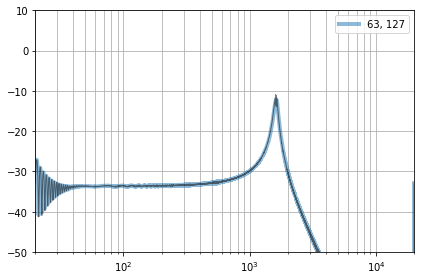

In [10]:
cutoffs = [63]
resonances = [127]
n = 0
for cutoff in cutoffs:
    for res in resonances:
        c = "C{:d}".format(n)
        n += 1
        
        f, H = frequency_response(vcf, cutoff, res)
        plt.semilogx(f, 20*np.ma.log10(abs(H)), color=c, linestyle="-", linewidth=4, alpha=0.5, label="{:d}, {:d}".format(cutoff, res))
        
        f, H = frequency_response(cy_vcf, cutoff, res)
        plt.semilogx(f, 20*np.ma.log10(abs(H)), color="k", linestyle="-", linewidth=1, alpha=0.5)
decorate_frequency_response();

## Profiling

In [11]:
x = get_chirp()
%timeit -r3 -n3 vcf(x, len(x), 63, 63)
%timeit -r3 -n3 f_vcf(x, len(x), 63, 63)
%timeit -r3 -n3 cy_vcf(x, len(x), 63, 63)

38.4 ms ± 82.3 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
23 ms ± 82.6 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
28.5 ms ± 697 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


## Mapping cutoff and resonance as integers

In the filter structure, the midi parameters (0-127) are mapped to the internal parameters:

- `g` = Cutoff frequency (squared mapping from around 0.02 to 0.8)
- `k` = Resonance (linear mapping from around 0.5 to 3.5)

Calculations may be speeded up internally by using integer representations.

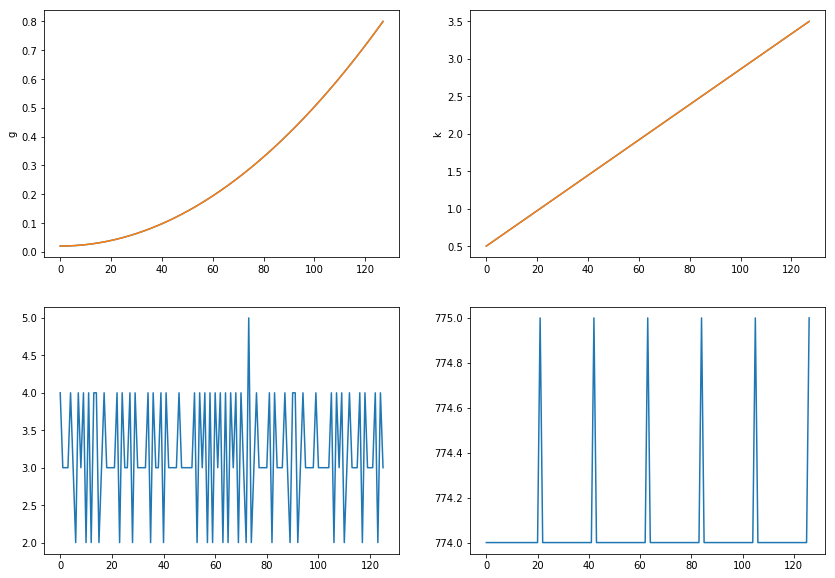

In [13]:
#print("\n".join(textwrap.wrap("{}".format([int(np.floor(2**15*map_cutoff(X))) for X in midi]))))
#print("\n".join(textwrap.wrap("{}".format([int(np.floor(2**15*map_resonance(X))) for X in midi]))))

def map_cutoff_q15(value):
    return [655, 656, 661, 669, 680, 694, 712, 733, 756, 783, 813, 847,
        883, 923, 965, 1011, 1061, 1113, 1168, 1227, 1289, 1354, 1422, 1493,
        1568, 1645, 1726, 1810, 1897, 1988, 2081, 2178, 2278, 2381, 2487,
        2596, 2709, 2824, 2943, 3065, 3190, 3319, 3450, 3585, 3723, 3864,
        4008, 4155, 4306, 4460, 4617, 4777, 4940, 5106, 5276, 5448, 5624,
        5803, 5986, 6171, 6360, 6551, 6746, 6944, 7146, 7350, 7558, 7768,
        7982, 8199, 8420, 8643, 8870, 9100, 9332, 9569, 9808, 10050, 10296,
        10545, 10797, 11052, 11310, 11572, 11836, 12104, 12375, 12649, 12926,
        13207, 13491, 13777, 14067, 14361, 14657, 14956, 15259, 15565, 15874,
        16186, 16501, 16820, 17142, 17467, 17795, 18126, 18460, 18798, 19138,
        19482, 19829, 20180, 20533, 20889, 21249, 21612, 21978, 22347, 22720,
        23095, 23474, 23856, 24241, 24629, 25021, 25415, 25813, 26214][value]
    
def map_resonance_q15(value):
    return [16384, 17158, 17932, 18706, 19480, 20254, 21028, 21802,
        22576, 23350, 24124, 24898, 25672, 26446, 27220, 27994, 28768, 29542,
        30316, 31090, 31864, 32638, 33413, 34187, 34961, 35735, 36509, 37283,
        38057, 38831, 39605, 40379, 41153, 41927, 42701, 43475, 44249, 45023,
        45797, 46571, 47345, 48119, 48893, 49668, 50442, 51216, 51990, 52764,
        53538, 54312, 55086, 55860, 56634, 57408, 58182, 58956, 59730, 60504,
        61278, 62052, 62826, 63600, 64374, 65148, 65923, 66697, 67471, 68245,
        69019, 69793, 70567, 71341, 72115, 72889, 73663, 74437, 75211, 75985,
        76759, 77533, 78307, 79081, 79855, 80629, 81403, 82178, 82952, 83726,
        84500, 85274, 86048, 86822, 87596, 88370, 89144, 89918, 90692, 91466,
        92240, 93014, 93788, 94562, 95336, 96110, 96884, 97658, 98433, 99207,
        99981, 100755, 101529, 102303, 103077, 103851, 104625, 105399, 106173,
        106947, 107721, 108495, 109269, 110043, 110817, 111591, 112365,
        113139, 113913, 114688][value]

midi = np.arange(128)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=[14, 10])
ax1.set_ylabel("g")
ax2.set_ylabel("k")

ax1.plot(midi, [map_cutoff(X) for X in midi])
ax1.plot(midi, [map_cutoff_q15(X)/2**15 for X in midi])

ax2.plot(midi, [map_resonance(X) for X in midi])
ax2.plot(midi, [map_resonance_q15(X)/2**15 for X in midi])

ax3.plot(midi[:-2], np.diff(np.diff([map_cutoff_q15(X) for X in midi])))
ax4.plot(midi[:-1], np.diff([map_resonance_q15(X) for X in midi]))

#for m in midi: print("{:3d} {:5.3f} {:5.3f}".format(m, map_cutoff(m), map_resonance(m)))